In [13]:
# from keras.layers import Input, Dense, Convolution2D, MaxPooling2D, UpSampling2D, Conv2D
# from keras.models import Model, load_model
# from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
# from keras import backend as K
# import keras

import numpy as np
import matplotlib.pyplot as plt

from os import listdir
from os import system
import os
import random

import imageio
import sys
import csv

In [14]:
def patch_diff(patch1, patch2):
    """Computing the sum of squared differences (SSD) between two images."""
    if patch1.shape != patch2.shape:
        print("Images don't have the same shape.")
        return
    return np.sum((np.array(patch1, dtype=np.float32) - np.array(patch2, dtype=np.float32))**2)

In [26]:
# image_path = '/home/niaki/Downloads/barbara.jpg'
# image_path = '/home/niaki/Downloads/house.tiff'
# image_path = '/home/niaki/Downloads/monarch.png'
# image_path = '/home/niaki/Downloads/Lenna.png'
image_path = '/home/niaki/Data/panel13/benelearn_paper/clean.jpg'


patch_size = 16
patch_width = patch_size
patch_height = patch_size

nearest_patches_nb = -1
query_stride = 300
compare_stride = 8
eps = 0.0001

nr_similar_patches = 40

In [27]:
image = imageio.imread(image_path)

# to be deleted
# image = image[:40, :40, :]

image_height = image.shape[0]
image_width = image.shape[1]

if nearest_patches_nb == -1:
    nearest_patches_nb = len(range(0, image_width - patch_size + 1, compare_stride)) * len(range(0, image_height - patch_size + 1, compare_stride))

In [5]:
# clean image

query_x_coords = []
query_y_coords = []

results_patches_diffs = {}
results_patches_x_coords = {}
results_patches_y_coords = {}
results_patches_positions = {}

counter_query_patches = 0

# just for the sake of output
total_nr_query_patches = len(range(0, image_width - patch_size + 1, query_stride)) * len(range(0, image_height - patch_size + 1, query_stride))

for y_query in range(0, image_width - patch_size + 1, query_stride):
    for x_query in range(0, image_height - patch_size + 1, query_stride):
        sys.stdout.write("\r" + str(counter_query_patches + 1) + "/" + str(total_nr_query_patches))
        
        query_x_coords.append(x_query)
        query_y_coords.append(y_query)        
    
        query_patch = image[x_query : x_query + patch_size, y_query : y_query + patch_size, :]
        
        counter_compare_patches = 0
        compare_patches_scores = {}
        
        patches_diffs = [1000000000]
        patches_x_coords = [-1]
        patches_y_coords = [-1]
        patches_positions = [-1]
        
        for y_compare in range(0, image_width - patch_size + 1, compare_stride):
            for x_compare in range(0, image_height - patch_size + 1, compare_stride):
                
                compare_patch = image[x_compare : x_compare + patch_size, y_compare : y_compare + patch_size, :]
                diff = patch_diff(query_patch, compare_patch)
                
                if diff < eps:
                    counter_compare_patches += 1
                    continue
                
                # sorting
                for i in range(len(patches_diffs)):
                    if diff < patches_diffs[i]:
                        patches_diffs.insert(i, diff)
                        patches_x_coords.insert(i, x_compare)
                        patches_y_coords.insert(i, y_compare)
                        patches_positions.insert(i, counter_compare_patches)
                        break
                
                counter_compare_patches += 1
                
        results_patches_diffs[counter_query_patches] = patches_diffs[:nearest_patches_nb]
        results_patches_x_coords[counter_query_patches] = patches_x_coords[:nearest_patches_nb]
        results_patches_y_coords[counter_query_patches] = patches_y_coords[:nearest_patches_nb]
        results_patches_positions[counter_query_patches] = patches_positions[:nearest_patches_nb]
        
        counter_query_patches += 1

25/25

In [28]:
image_noisy = image

In [29]:
theta = np.load('/home/niaki/temp/encoderChenEtAl_RGB_400it.npy')

input_size = 16 * 16 *3
hidden_size = 128

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

W1 = theta[0:hidden_size * input_size].reshape(hidden_size, input_size)
W2 = theta[hidden_size * input_size:2 * hidden_size * input_size].reshape(input_size, hidden_size)
b1 = theta[2 * hidden_size * input_size:2 * hidden_size * input_size + hidden_size]
b2 = theta[2 * hidden_size * input_size + hidden_size:]

query_x_coords = []
query_y_coords = []

results_noisy_descr_patches_diffs = {}
results_noisy_descr_patches_x_coords = {}
results_noisy_descr_patches_y_coords = {}
results_noisy_descr_patches_positions = {}

counter_query_patches = 0

# just for the sake of output
total_nr_query_patches = len(range(0, image_width - patch_size + 1, query_stride)) * len(range(0, image_height - patch_size + 1, query_stride))

for y_query in range(0, image_width - patch_size + 1, query_stride):
    for x_query in range(0, image_height - patch_size + 1, query_stride):
#             sys.stdout.write("\r" + str(counter_query_patches + 1) + "/" + str(total_nr_query_patches))

        query_x_coords.append(x_query)
        query_y_coords.append(y_query)   

        query_patch = image_noisy[x_query : x_query + patch_size, y_query : y_query + patch_size, :]
#             query_patch_descr = encoder.predict(np.expand_dims(query_patch, axis=0))[0]
#         query_patch_descr = np.mean(query_patch)
        data = np.expand_dims(query_patch.reshape(patch_size * patch_size * 3), axis=1)
        z2 = W1.dot(data) + np.tile(b1, (1, 1)).transpose()
        query_patch_descr = sigmoid(z2)


        counter_compare_patches = 0
        compare_patches_scores = {}

        patches_diffs = [1000000000]
        patches_x_coords = [-1]
        patches_y_coords = [-1]
        patches_positions = [-1]

        for y_compare in range(0, image_width - patch_size + 1, compare_stride):
            for x_compare in range(0, image_height - patch_size + 1, compare_stride):

                compare_patch = image_noisy[x_compare : x_compare + patch_size, y_compare : y_compare + patch_size, :]
#                     compare_patch_descr = encoder.predict(np.expand_dims(compare_patch, axis=0))[0]
#                 compare_patch_descr = np.mean(compare_patch)
                data = np.expand_dims(compare_patch.reshape(patch_size * patch_size * 3), axis=1)
                z2 = W1.dot(data) + np.tile(b1, (1, 1)).transpose()
                compare_patch_descr = sigmoid(z2)    

                diff = patch_diff(query_patch_descr, compare_patch_descr)
#                 diff = (query_patch_descr - compare_patch_descr)**2

                if diff < eps:
                    counter_compare_patches += 1
                    continue

                # sorting
                for i in range(len(patches_diffs)):
                    if diff < patches_diffs[i]:
                        patches_diffs.insert(i, diff)
                        patches_x_coords.insert(i, x_compare)
                        patches_y_coords.insert(i, y_compare)
                        patches_positions.insert(i, counter_compare_patches)
                        break

                counter_compare_patches += 1

        results_noisy_descr_patches_diffs[counter_query_patches] = patches_diffs[:nearest_patches_nb]
        results_noisy_descr_patches_x_coords[counter_query_patches] = patches_x_coords[:nearest_patches_nb]
        results_noisy_descr_patches_y_coords[counter_query_patches] = patches_y_coords[:nearest_patches_nb]
        results_noisy_descr_patches_positions[counter_query_patches] = patches_positions[:nearest_patches_nb]

        counter_query_patches += 1

/scratch/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in exp
  import sys


In [9]:
ssds = []

# nr_similar_patches = 20

for q_it in range(total_nr_query_patches):
    for c_it in range(nr_similar_patches):
        
        # getting the query patch from the clean image
        x_query = query_x_coords[q_it]
        y_query = query_y_coords[q_it]
        query_patch = image[x_query : x_query + patch_size, y_query : y_query + patch_size, :]
        
        # getting the compare patch from the clean image
        x_compare = results_noisy_descr_patches_x_coords[q_it][c_it]
        y_compare = results_noisy_descr_patches_y_coords[q_it][c_it]
        compare_patch = image[x_compare : x_compare + patch_size, y_compare : y_compare + patch_size, :]
        
        # calculating the difference in the clean image
        actual_diff = patch_diff(query_patch, compare_patch)
        ssds.append(actual_diff)
        
ssds = np.array(ssds)

/scratch/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  


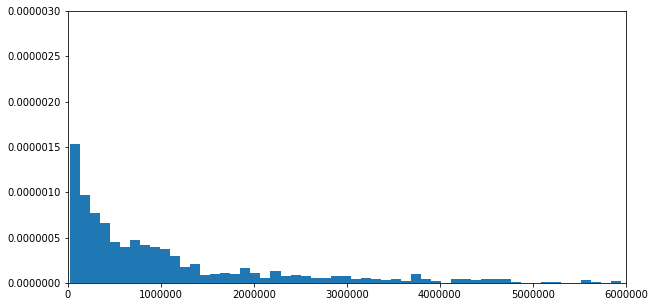

In [11]:
plt.figure(figsize=(10, 5))
plt.hist(ssds, 100, normed=1)
plt.xlim(0, 6000000)
plt.ylim(0, 0.000003)
plt.show()

In [12]:
ssds

array([  782429.,   329489.,   328617.,   174191.,   363527.,    74961.,
         854359.,   157128.,   378993.,   360670.,   238030.,   687584.,
         522506.,   592766.,   548979.,   130431.,   382029.,   121064.,
         433678.,   556339.,   285183.,   205862.,   454337.,   186262.,
        1154305.,   384828.,   415965.,  1741215.,   517650.,   108249.,
         151037.,   129039.,   109211.,  2120980.,  2337883.,  2429463.,
        2964850.,  3782303.,  4353968.,  4156386.,   919959.,    91208.,
          50466.,   513949.,  1085868.,  1194573.,   779886.,  1184612.,
        1566870.,   950587.,   901404.,  1710615.,   821431.,  1173723.,
         430163.,   178625.,   146724.,   155569.,  1078626.,   511264.,
         235024.,   486451.,    48815.,   229972.,   873921.,   711644.,
         371388.,  1958771.,  1934119.,   254427.,   253164.,  1280540.,
         729858.,    62374.,   497375.,  1020735.,  1102895.,   493142.,
         154573.,   284045.,   417416.,    62816., 

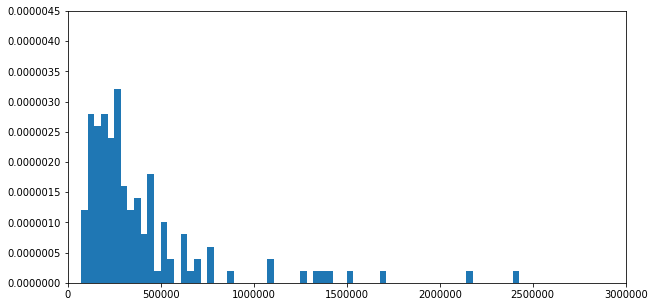

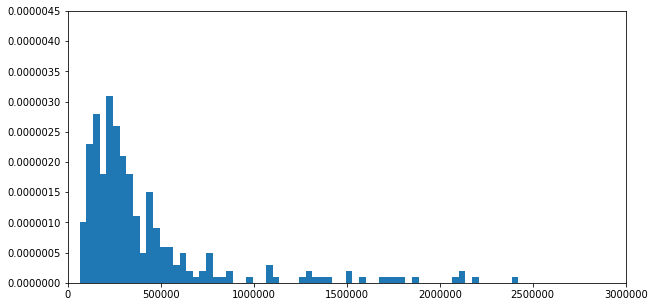

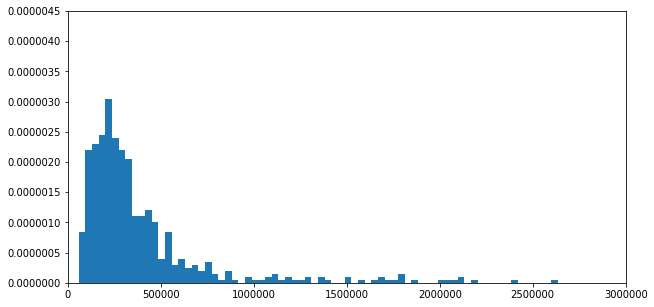

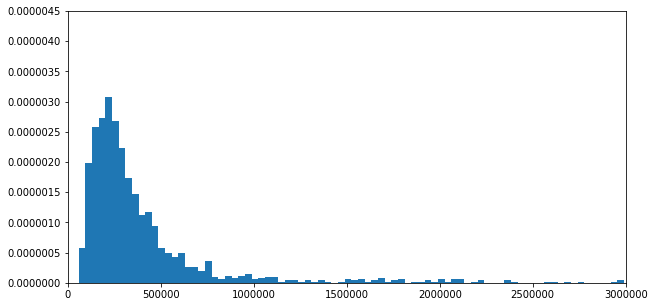

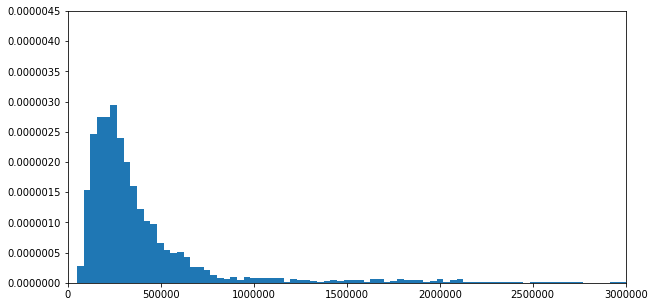

In [61]:
for nr_similar_patches in [5,10,20,50,100]:
    ssds = []

    for q_it in range(total_nr_query_patches):
        for c_it in range(nr_similar_patches):

            # getting the query patch from the clean image
            x_query = query_x_coords[q_it]
            y_query = query_y_coords[q_it]
            query_patch = image[x_query : x_query + patch_size, y_query : y_query + patch_size, :]

            # getting the compare patch from the clean image
            x_compare = results_noisy_descr_patches_x_coords[q_it][c_it]
            y_compare = results_noisy_descr_patches_y_coords[q_it][c_it]
            compare_patch = image[x_compare : x_compare + patch_size, y_compare : y_compare + patch_size, :]

            # calculating the difference in the clean image
            actual_diff = patch_diff(query_patch, compare_patch)
            ssds.append(actual_diff)

    ssds = np.array(ssds)
    
    plt.figure(figsize=(10, 5))
    plt.hist(ssds, bins=200, density=1)
    plt.xlim(0, 3000000)
    plt.ylim(0, 0.0000045)
    plt.show()

In [31]:
ssds.shape

(2800,)

In [35]:
print(*ssds, sep='\n')

129397.0
101618.0
139086.0
359961.0
94483.0
234696.0
144049.0
154517.0
470876.0
96983.0
206560.0
159335.0
94366.0
354070.0
103628.0
150101.0
99310.0
315602.0
306291.0
179032.0
251446.0
452292.0
272765.0
143448.0
319321.0
123034.0
236293.0
91877.0
221653.0
214021.0
219286.0
382150.0
137782.0
231311.0
261832.0
158633.0
116166.0
241333.0
265262.0
304448.0
356149.0
181043.0
221154.0
321979.0
235271.0
226017.0
194734.0
94402.0
125845.0
151724.0
381578.0
150255.0
113981.0
162021.0
246643.0
502329.0
247531.0
297383.0
311517.0
151300.0
265016.0
94612.0
248978.0
236979.0
212390.0
339948.0
113601.0
205951.0
172402.0
108491.0
143231.0
237775.0
133641.0
266268.0
142520.0
187808.0
316675.0
159449.0
248832.0
223428.0
535895.0
365933.0
105776.0
199225.0
117417.0
173177.0
363537.0
294843.0
290088.0
128933.0
90697.0
308061.0
193809.0
301655.0
367000.0
130078.0
70970.0
135879.0
122567.0
236894.0
453733.0
342449.0
285318.0
267906.0
406317.0
528450.0
239895.0
451319.0
965688.0
217107.0
420192.0
433733.0
5

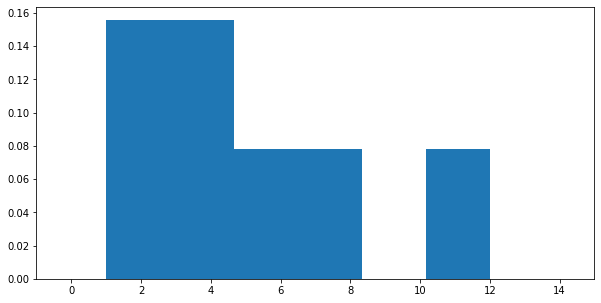

In [62]:
temp = [1,2,3,4,8,6,12]
plt.figure(figsize=(10, 5))
plt.hist(temp, bins=6, density=1)
plt.xlim(-1, 15)
plt.show()

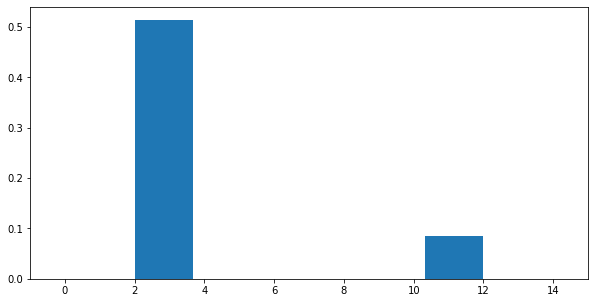

In [63]:
temp = [2,2,2,2,2,2,12]
plt.figure(figsize=(10, 5))
plt.hist(temp, bins=6, density=1)
plt.xlim(-1, 15)
plt.show()

In [65]:
import pickle
import datetime

pickle_file_path = 'zimnica/histograms_chen_panel13_qstride300_cstride8_' + datetime.datetime.now().strftime("%Y%m%d_%H%M%S") + '.pickle'
try:
    pickle.dump((total_nr_query_patches, results_noisy_descr_patches_diffs, results_noisy_descr_patches_x_coords, results_noisy_descr_patches_y_coords, results_noisy_descr_patches_positions, query_x_coords, query_y_coords, image, patch_size), open(pickle_file_path, "wb"))
except Exception as e:
    print("Problem while trying to pickle: ", str(e))